In [2]:
import pandas as pd
import requests
import json
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import config
import time

In [3]:
url = "https://raw.githubusercontent.com/Flores-Kevin/rage-against-machine-learning/molly/resources/regional-usa-weekly-2022-10-06.csv"

In [4]:
df = pd.read_csv(url)

In [5]:
df.head()

,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,weeks_on_chart,streams
0,1,spotify:track:3nqQXoyQOWXiESFLlDF1hG,"Sam Smith, Kim Petras",Unholy (feat. Kim Petras),EMI,1,1,2,12004993
1,2,spotify:track:4k6Uh1HXdhtusDW5y8Gbvy,Steve Lacy,Bad Habit,L-M Records/RCA Records,1,2,14,10425163
2,3,spotify:track:1IHWl5LamUGEuP4ozKQSXZ,Bad Bunny,Tití Me Preguntó,Rimas Entertainment LLC,3,7,22,6742213
3,4,spotify:track:4Dvkj6JhhA12EX05fT7y2e,Harry Styles,As It Was,Columbia,1,3,27,6540607
4,5,spotify:track:1xK59OXxi2TAAAbmZK0kBL,d4vd,Romantic Homicide,Darkroom/Interscope Records,5,5,9,6375518


In [6]:
df.columns

Index(['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank',
       'previous_rank', 'weeks_on_chart', 'streams'],
      dtype='object')

In [7]:
#extracting track id (removing "spotify:track:" from track id in csv)
track_id_series = df.uri.str[14:]

In [8]:
#convert to df and rename column
track_id_df = track_id_series.to_frame().rename(columns={"uri":"track_id"})

In [9]:
#merge dfs
df = df.merge(track_id_df, how="inner", left_index=True, right_index=True)
df = df[["rank", "track_id", "artist_names", "track_name", "peak_rank", "previous_rank", "weeks_on_chart", "streams"]]

,rank,track_id,artist_names,track_name,peak_rank,previous_rank,weeks_on_chart,streams
0,1,3nqQXoyQOWXiESFLlDF1hG,"Sam Smith, Kim Petras",Unholy (feat. Kim Petras),1,1,2,12004993
1,2,4k6Uh1HXdhtusDW5y8Gbvy,Steve Lacy,Bad Habit,1,2,14,10425163
2,3,1IHWl5LamUGEuP4ozKQSXZ,Bad Bunny,Tití Me Preguntó,3,7,22,6742213
3,4,4Dvkj6JhhA12EX05fT7y2e,Harry Styles,As It Was,1,3,27,6540607
4,5,1xK59OXxi2TAAAbmZK0kBL,d4vd,Romantic Homicide,5,5,9,6375518
...,...,...,...,...,...,...,...,...
195,196,3yfqSUWxFvZELEM4PmlwIR,Eminem,The Real Slim Shady,48,194,28,1615334
196,197,6UelLqGlWMcVH1E5c4H7lY,Harry Styles,Watermelon Sugar,4,178,143,1604146
197,198,48q0vSHcJdhK3IiXH8C5WJ,Arctic Monkeys,Why'd You Only Call Me When You're High?,111,-1,14,1603256
198,199,4MzXwWMhyBbmu6hOcLVD49,"Bad Bunny, Jhay Cortez",DÁKITI,1,186,92,1601541


In [11]:
first_track_id = df["track_id"][0]

In [12]:
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': config.client_id,
    'client_secret': config.client_secret,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

In [13]:
#base URL for Spotify API search
search_url = 'https://api.spotify.com/v1/search'

#In order to access, we send a properly formed GET request to the API server, with our access_token in the header. Let’s save this header info now, in the following very specific format:
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

In [14]:
#base URL for Spotify API
base_url = 'https://api.spotify.com/v1/'

track_response = requests.get(base_url + 'audio-features/' + first_track_id, headers=headers).json()

In [15]:
#empty lists to store song data
global_danceability = []
global_energy = []
global_key = []
global_loudness = []
global_mode = []
global_speechiness = []
global_acousticness = []
global_instrumentalness = []
global_liveness = []
global_valence = []
global_tempo = []
global_id_num = []
global_track_href = []
global_analysis_url = []
global_duration_mins = []
global_time_signature = []

In [16]:
#loop through dataframe, use track id to look up songs in spotify api and grab each one's audio features
for t in df["track_id"]:
    global_response = requests.get(base_url + 'audio-features/' + t, headers=headers).json()
    
    time.sleep(1)
    
    #fill in track info for each audio feature / empty list
    global_danceability.append(global_response["danceability"])
    global_energy.append(global_response["energy"])
    global_key.append(global_response["key"])
    global_loudness.append(global_response["loudness"])
    global_mode.append(global_response["mode"])
    global_speechiness.append(global_response["speechiness"])
    global_acousticness.append(global_response["acousticness"])
    global_instrumentalness.append(global_response["instrumentalness"])
    global_liveness.append(global_response["liveness"])
    global_valence.append(global_response["valence"])
    global_tempo.append(global_response["tempo"])
    global_id_num.append(global_response["id"])
    global_track_href.append(global_response["track_href"])
    global_analysis_url.append(global_response["analysis_url"])    
    #duration recorded in api in milliseconds, converting to minutes here
    global_duration_mins.append(round((global_response["duration_ms"] / 60000),2))
    global_time_signature.append(global_response["time_signature"])

In [17]:
print(global_energy)

[0.472, 0.494, 0.715, 0.731, 0.544, 0.712, 0.878, 0.192, 0.965, 0.673, 0.797, 0.336, 0.67, 0.525, 0.807, 0.783, 0.317, 0.594, 0.475, 0.85, 0.642, 0.601, 0.521, 0.689, 0.728, 0.305, 0.69, 0.525, 0.665, 0.715, 0.674, 0.745, 0.743, 0.852, 0.714, 0.5, 0.686, 0.657, 0.772, 0.498, 0.568, 0.547, 0.69, 0.764, 0.647, 0.509, 0.582, 0.611, 0.433, 0.9, 0.467, 0.527, 0.912, 0.763, 0.782, 0.799, 0.628, 0.531, 0.373, 0.679, 0.818, 0.366, 0.514, 0.424, 0.536, 0.903, 0.68, 0.737, 0.47, 0.409, 0.516, 0.559, 0.648, 0.737, 0.534, 0.427, 0.604, 0.564, 0.684, 0.587, 0.646, 0.449, 0.839, 0.738, 0.786, 0.75, 0.911, 0.722, 0.795, 0.772, 0.517, 0.622, 0.479, 0.73, 0.593, 0.769, 0.741, 0.522, 0.5, 0.592, 0.662, 0.417, 0.344, 0.75, 0.623, 0.697, 0.603, 0.806, 0.734, 0.529, 0.657, 0.508, 0.691, 0.346, 0.636, 0.664, 0.251, 0.566, 0.545, 0.792, 0.573, 0.225, 0.495, 0.37, 0.534, 0.591, 0.695, 0.858, 0.585, 0.858, 0.881, 0.762, 0.268, 0.538, 0.764, 0.537, 0.796, 0.492, 0.521, 0.369, 0.871, 0.766, 0.518, 0.601, 0.744, 

In [18]:
# global_songs_dict to hold data gathered from the api
global_songs_dict = {
    "track_id": global_id_num,
    "danceability": global_danceability,
    "energy": global_energy,
    "key": global_key,
    "loudness": global_loudness,
    "mode": global_mode,
    "speechiness": global_speechiness,
    "acousticness": global_acousticness,
    "instrumentalness": global_instrumentalness,
    "liveness": global_liveness,
    "valence": global_valence,
    "tempo": global_tempo,
    "duration_mins": global_duration_mins,
    "time_signature": global_time_signature,
    "track_href": global_track_href,
    "analysis_url": global_analysis_url
}

In [19]:
#convert dictionary to a dataframe
global_info_df = pd.DataFrame(global_songs_dict)
global_info_df.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,time_signature,track_href,analysis_url
0,3nqQXoyQOWXiESFLlDF1hG,0.714,0.472,2,-7.375,1,0.0864,0.0130,0.000005,0.266,0.238,131.121,2.62,4,https://api.spotify.com/v1/tracks/3nqQXoyQOWXi...,https://api.spotify.com/v1/audio-analysis/3nqQ...
1,4k6Uh1HXdhtusDW5y8Gbvy,0.686,0.494,1,-7.093,1,0.0355,0.6130,0.000058,0.402,0.700,168.946,3.87,4,https://api.spotify.com/v1/tracks/4k6Uh1HXdhtu...,https://api.spotify.com/v1/audio-analysis/4k6U...
2,1IHWl5LamUGEuP4ozKQSXZ,0.650,0.715,5,-5.198,0,0.2530,0.0993,0.000291,0.126,0.187,106.672,4.06,4,https://api.spotify.com/v1/tracks/1IHWl5LamUGE...,https://api.spotify.com/v1/audio-analysis/1IHW...
3,4Dvkj6JhhA12EX05fT7y2e,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.311,0.662,173.930,2.79,4,https://api.spotify.com/v1/tracks/4Dvkj6JhhA12...,https://api.spotify.com/v1/audio-analysis/4Dvk...
4,1xK59OXxi2TAAAbmZK0kBL,0.571,0.544,6,-10.613,1,0.0299,0.4530,0.008050,0.322,0.216,132.052,2.21,4,https://api.spotify.com/v1/tracks/1xK59OXxi2TA...,https://api.spotify.com/v1/audio-analysis/1xK5...


In [20]:
global_info_df = global_info_df.drop(columns={'track_id','track_href','analysis_url'})

In [21]:
#Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(global_info_df)

In [ ]:
#attempting to do some cosine similarity craziness

non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    # Find cosine similarity between the playlist and the complete song set
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)

In [22]:
#Reducing dimensionality with pca
pca = PCA(n_components = .9)
df_pca = pca.fit_transform(df_scaled)

In [23]:
#Run t-SNE on the pca output to further reduce dimensionality.
tsne = TSNE()
df_tsne = tsne.fit_transform(df_pca)

In [24]:
mode = global_info_df['valence']

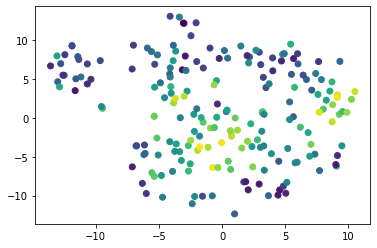

In [25]:
#Plotting the tsne numpy array
plt.scatter(df_tsne[:,0],df_tsne[:,1],c=mode)

In [45]:
# from sklearn.ensemble.forest import RandomForestRegressor

# # Can combine step above with this
# forest = RandomForestRegressor(random_state=42, max_depth=5, max_features=10) 
# forest.fit(X,Y)
# importances = forest.feature_importances_
# indices = np.argsort(importances)[::-1]

# # Print the feature rankings
# print("Playlist ranking:")
  
# for f in range(len(importances)):
#     print("%d. %s %f " % (f + 1, 
#             X.columns[f], 
#             importances[indices[f]]))

In [55]:
search_track = input("Please name a song: ")

Please name a song:  Yesterday


In [56]:
search_artist = input("Please name that song's artist: ")

Please name that song's artist:  The Beatles


In [57]:
response = requests.get(search_url + '?q=track%3A' + search_track + '%20artist%3A' + search_artist + '&type=track%2Cartist&limit=1', headers=headers).json()

In [59]:
response

{'error': {'status': 401, 'message': 'The access token expired'}}